In [0]:
#Linking the Google colab to google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
filename = '/content/drive/My Drive/Summarizer_Dataset/tokens_10000.pkl'    #File Location to load after pre-processing


In [0]:
FN = 'vocabulary-embedding'
seed=42
vocab_size = 40000
embedding_dim = 100
lower = False # dont lower case the text


In [0]:
import cPickle as pickle
FN0 = 'tokens' # this is the name of the data file which I assume you already have
with open('/content/drive/My Drive/Summarizer_dataset/tokens_10000 (1).pkl', 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [0]:
if lower:
    heads = [h.lower() for h in heads]

In [0]:
if lower:
    desc = [h.lower() for h in desc]

In [0]:
i=0
heads[i]
desc[i]

u'VETERANS saluted Worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies.  The Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday.  The club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders.  Father-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country.  He said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up.  "We even had an old chap travel from Droitwich and he was late on parade by three hours.  "It\'s generated a lot of interest and I estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. Onwards and upwards."  He said the management at the pub had been extremely hospitable

In [0]:
  len(heads),len(set(heads))

(10000, 9941)

In [0]:
len(desc),len(set(desc))

(10000, 9899)

In [0]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [0]:
vocab, vocabcount = get_vocab(heads+desc)

In [0]:
print vocab[:50]
print '...',len(vocab)

[u'the', u'and', u'to', u'of', u'a', u'in', u'for', u'is', u'on', u'that', u'with', u'The', u'at', u'as', u'was', u'be', u'by', u'are', u'from', u'have', u'has', u'it', u'will', u'I', u'this', u'an', u'or', u'you', u'not', u'his', u'he', u'their', u'-', u'more', u'but', u'said', u'who', u'they', u'we', u'which', u'can', u'about', u'its', u'been', u'our', u'all', u'were', u'had', u'your', u'one']
... 289380


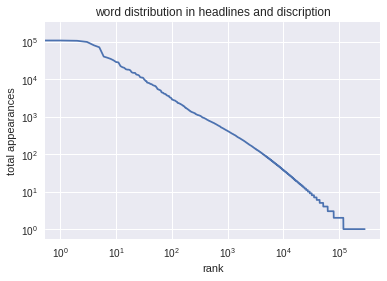

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [0]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [0]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.iteritems())

    return word2idx, idx2word

In [0]:
word2idx, idx2word = get_idx(vocab, vocabcount)

In [0]:
fname = 'glove.6B.%dd.txt'%embedding_dim
from keras.utils import get_file
path = 'glove.6B.zip'
path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip", cache_dir='/content/drive/My\ Drive/Summarizer_dataset')
!unzip {'/content/drive/My\ Drive/Summarizer_dataset'}/{'glove.6B.zip'}

Using TensorFlow backend.


862191616/862182613 [==============================] - 216s 0us/step
Archive:  /content/drive/My Drive/Summarizer_dataset/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
glove_name = './' + fname
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols


400000

In [0]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = map(float,l[1:])
        i += 1
glove_embedding_weights *= globale_scale

In [0]:
glove_embedding_weights.std()

0.04081572760019029

In [0]:
for w,i in glove_index_dict.iteritems():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [0]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print 'random-embedding/glove scale', scale, 'std', embedding.std()

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print 'number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size)

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
number of tokens, in small vocab, found in glove and copied to embedding 27200 0.68


In [0]:
glove_thr = 0.5

In [0]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [0]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.iteritems():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print '# of glove substitutes found', len(glove_match)

# of glove substitutes found 48048


In [0]:
for orig, sub, score in glove_match[-10:]:
    print score, orig,'=>', idx2word[sub]

0.5000697194501305 Swara => Hexa
0.5000578493182842 Lynnwood => Whitemarsh
0.5000490738752257 bails => wipes
0.5000480235662031 Motherfucker => fucking
0.5000469909711531 chiming => bells
0.5000343628037485 potshot => Dianabol
0.500030129352899 grout => stain
0.500019190694808 codefendant => 55-year-old
0.5000046357647958 Ridgeway => Stoney
0.5000018196995617 perpetuities => D-Link


In [0]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

In [0]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

10000

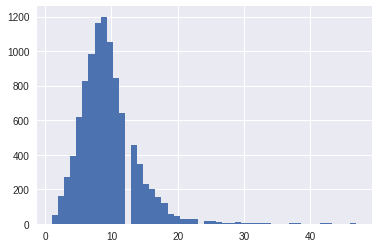

In [0]:
plt.hist(map(len,Y),bins=50);

In [0]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

10000

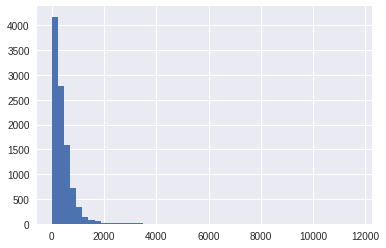

In [0]:
plt.hist(map(len,X),bins=50);

In [0]:
import cPickle as pickle
with open('/content/drive/My Drive/Summarizer_dataset/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [0]:
import cPickle as pickle
with open('/content/drive/My Drive/Summarizer_dataset/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)